In [37]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from geopy.distance import geodesic
pd.set_option('display.max_columns', None)

In [38]:
url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-zuerich?pn=2&r=10'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
raw_data = soup.find(id='state')

jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
#raw_data.string.replace('undefined', 'null')


In [39]:
f = open("sample.txt", "w")
f.write(json.dumps(jason_data))
f.close()

In [40]:
# getting the published empty flats of Zurich in a 10km radius
result_list = []
max = 40 #number of web pages to scrape

for i in range(max):
    url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-zuerich?pn={}&r=10'.format(i+1)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_data = soup.find(id='state')
    jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
    data_list = jason_data['pages']['searchResult']['resultData']['listData']

    page_list = []

    for elem in data_list:
        if 'price' in elem: price = elem['price']
        else: price = np.nan

        if 'surfaceLiving' in elem: sl = elem['surfaceLiving']
        else: sl = np.nan

        if 'numberOfRooms' in elem: nor = elem['numberOfRooms']
        else: nor = np.nan

        if 'title' in elem: ttl = elem['title']
        else: ttl = np.nan

        if 'latitude' in elem: lat = elem['latitude']
        else: lat = np.nan

        if 'longitude' in elem: lon = elem['longitude']
        else: lon = np.nan

        page_list.append([elem['id'], price, nor, sl, ttl, elem['zip'], lat, lon])

    result_list += page_list

result_list[10:12]

[[6264045,
  1950,
  3.5,
  109,
  'Charmante 3.5-Zimmer-Maisonette befristet zu vermieten bis 30.09.2021!',
  '8057',
  47.39867,
  8.55382],
 [6215014,
  4060,
  3.5,
  127,
  'Moderne Wohnung an zentraler Lage',
  '8045',
  47.36107,
  8.52252]]

In [61]:
flats_df = pd.DataFrame(result_list)
flats_df.columns = ['ID', 'Price', 'RoomNr', 'Surface', 'Title', 'ZIP', 'Latitude', 'Longitude']

flats_df.dropna(inplace=True)
flats_df['Title'] = flats_df['Title'].str.lower()

flats_df['Vista'] = 0
filter1 = flats_df['Title'].str.contains('blick|sicht|anstoss')
filter2 = ~flats_df['Title'].str.contains('besichtigung')
flats_df.loc[filter1 & filter2, 'Vista'] = 1

flats_df['Bright'] = 0
filter3 = flats_df['Title'].str.contains("hell|licht|sonnig")
flats_df.loc[filter3, 'Bright'] = 1

flats_df['New'] = 0
filter4 = flats_df['Title'].str.contains("neu|new")
flats_df.loc[filter4, 'New'] = 1

flats_df['Furnished'] = 0
filter5 = flats_df['Title'].str.contains("möbliert|moebliert|furnished")
flats_df.loc[filter5, 'Furnished'] = 1

#flats_df['Furnished'].value_counts()
flats_df.describe()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished
count,8.250000e+02,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000
mean,6.045005e+06,2489.681212,2.918788,73.172121,47.388895,8.534256,0.050909,0.066667,0.066667,0.144242
std,5.707800e+05,1330.069086,1.239793,37.360705,0.034354,0.053778,0.219945,0.249595,0.249595,0.351549
min,2.141913e+06,450.000000,1.000000,1.000000,47.290900,8.404090,0.000000,0.000000,0.000000,0.000000
25%,6.089055e+06,1780.000000,2.000000,47.000000,47.366660,8.505170,0.000000,0.000000,0.000000,0.000000
50%,6.254108e+06,2190.000000,3.000000,70.000000,47.387910,8.541410,0.000000,0.000000,0.000000,0.000000
75%,6.295832e+06,2800.000000,3.500000,95.000000,47.412360,8.564300,0.000000,0.000000,0.000000,0.000000
max,6.312845e+06,19000.000000,7.500000,284.000000,47.467300,8.661140,1.000000,1.000000,1.000000,1.000000


In [62]:
#Adding each flats distance to the Zurich Main Station
geodesic((50,3), (47.3786,8.5379)).kilometers

distance_list = []
for id, lat, lon in zip(flats_df['ID'], flats_df['Latitude'], flats_df['Longitude']):
    distance_list.append(geodesic((lat,lon), (47.3786,8.5379)).kilometers)

flats_df['StationDist'] = pd.DataFrame(distance_list)
flats_df.dropna(inplace=True)
flats_df.describe()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist
count,7.250000e+02,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,6.050280e+06,2220.875862,2.810345,68.146207,47.391191,8.533288,0.044138,0.067586,0.064828,0.132414,4.921566
std,5.681501e+05,704.945822,1.166506,30.817151,0.034600,0.055698,0.205543,0.251208,0.246391,0.339174,2.813177
min,2.141913e+06,670.000000,1.000000,1.000000,47.290900,8.404090,0.000000,0.000000,0.000000,0.000000,0.372956
25%,6.089982e+06,1772.000000,2.000000,45.000000,47.369730,8.497910,0.000000,0.000000,0.000000,0.000000,2.305665
50%,6.255468e+06,2126.000000,3.000000,69.000000,47.391740,8.538880,0.000000,0.000000,0.000000,0.000000,4.673300
75%,6.296853e+06,2560.000000,3.500000,90.000000,47.414450,8.567170,0.000000,0.000000,0.000000,0.000000,7.428657
max,6.312691e+06,7500.000000,6.500000,216.000000,47.467300,8.661140,1.000000,1.000000,1.000000,1.000000,10.580974


In [68]:
#Cleaning out statistical outliers
cleaner = flats_df[flats_df['Surface'] != 1 ]
flats_filtered = flats_df #this cell doesnt change anything
cleaner.describe()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist
count,7.240000e+02,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,6.050811e+06,2221.947514,2.811464,68.238950,47.391160,8.533209,0.044199,0.067680,0.064917,0.132597,4.924241
std,5.683631e+05,704.841958,1.166922,30.737043,0.034613,0.055695,0.205679,0.251369,0.246550,0.339373,2.814199
min,2.141913e+06,670.000000,1.000000,11.000000,47.290900,8.404090,0.000000,0.000000,0.000000,0.000000,0.372956
25%,6.090813e+06,1774.250000,2.000000,45.000000,47.369682,8.497495,0.000000,0.000000,0.000000,0.000000,2.296707
50%,6.255636e+06,2128.000000,3.000000,69.000000,47.391695,8.538555,0.000000,0.000000,0.000000,0.000000,4.681388
75%,6.296859e+06,2562.500000,3.500000,90.000000,47.414450,8.567020,0.000000,0.000000,0.000000,0.000000,7.438199
max,6.312691e+06,7500.000000,6.500000,216.000000,47.467300,8.661140,1.000000,1.000000,1.000000,1.000000,10.580974


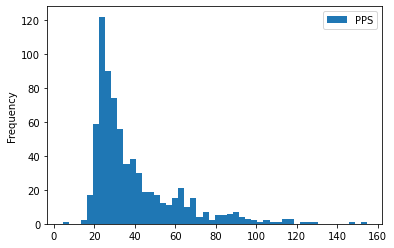

In [69]:
#Calculating price per squaremeter
pps = flats_filtered['Price'] / flats_filtered['Surface']
flats_filtered['PPS'] = pps
flats_filtered[['PPS']].plot.hist(bins=50)

In [94]:
cluster_df = flats_filtered.set_index('ID')
cluster_df = cluster_df[['PPS', 'StationDist']]
cluster_df.dropna(inplace=True)
X = normalize(cluster_df.to_numpy())
#X = cluster_df.to_numpy()
clusters = KMeans(n_clusters=2).fit_predict(X)
cluster_df['Cat'] = clusters

In [99]:
#cluster_df[cluster_df['Cat'] == 1].describe()
flats_filtered['PPS'].corr()

TypeError: corr() missing 1 required positional argument: 'other'

In [96]:
# create map of zurich using latitude and longitude values
map_zurich = folium.Map(location=[47.38, 8.53], zoom_start=11.5)

linear = cm.LinearColormap(
    ['blue', 'green', 'yellow'],
    vmin=0, vmax=2
)

linear

# add markers to map
for lat, lng, price, cat in zip(flats_df['Latitude'], flats_df['Longitude'], flats_df['Price'], cluster_df['Cat']):
    label = folium.Popup(str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(cat),
        fill=True,
        fill_color=linear(cat),
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)

map_zurich

In [48]:
flats_sample = flats_df.sample(100, random_state=5)
#flats_sample.set_index('ID', inplace=True)
flats_sample

,ID,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS
186,6279342,1600.0,1.0,40.0,wohnung nähe hb ab 15m2 mit hotelservice ab fr...,8001,47.37619,8.54000,0,0,0,0,8.592984,40.000000
736,6286104,3000.0,3.5,92.0,trendiges wohnen in der überbauung hamilton-view,8152,47.42135,8.56308,0,0,0,0,1.571022,32.608696
821,5972873,3860.0,3.5,92.0,traumhafte attikawohnung mit sonniger terrasse!,8053,47.35965,8.59813,0,1,0,0,5.605911,41.956522
277,5943214,1790.0,1.5,22.0,what else?,8004,47.37595,8.51619,0,0,0,0,3.723327,81.363636
158,6225591,1545.0,3.0,61.0,alle guten dinge sind drei - zimmer,8302,47.45027,8.58043,0,0,0,0,8.774606,25.327869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,6269027,1700.0,3.0,62.0,profitieren sie von der nähe zum dorfkern,8153,47.44929,8.53074,0,0,0,0,8.067728,27.419355
389,5919524,1990.0,1.5,33.0,urbanes wohnen im business apartment sihlhof,8134,47.32135,8.52241,0,0,0,0,3.997873,60.303030
29,6291416,1540.0,3.0,62.0,alle guten dinge sind 3 - zimmer,8302,47.45185,8.58667,0,0,0,0,4.285454,24.838710
343,6302949,1895.0,3.0,60.0,neu renovierte 3-zimmerwohnung an zentraler lage,8048,47.38967,8.48830,0,0,1,0,2.345021,31.583333


In [49]:
CLIENT_ID = 'VV5H111QRCSXOLD5LF52CDDBI1S1QPDX5BFBOI3IJQHGYI4L' # your Foursquare ID
CLIENT_SECRET = 'TEH4SQMZBUB1VHCJZQYNLNHCQTBLTEXIHBLY1VWM1FMSYU1N' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 500
LIMIT = 50

In [50]:
venues_list=[]

for flatID, flatLat, flatLon in zip(flats_sample['ID'], flats_sample['Latitude'], flats_sample['Longitude']):

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, flatLat, flatLon, VERSION, RADIUS, LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        venues_list.append([
            flatID,
            v['venue']['categories'][0]['name']
        ])

venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['ID', 'Category']

onehot = pd.get_dummies(venues_df['Category'],  prefix="", prefix_sep="")
onehot['ID'] = venues_df['ID']
onehot = onehot.groupby('ID').sum()
onehot

,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Beer Bar,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Rink,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Venue,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Rental Car Location,Restaurant,River,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Watch Shop,Waterfront,Wine Bar,Wine Shop,Women's Store
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2141913,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4472737,0,0,0,0,0,0,1,0,0,0,0,2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8,0,0,1,2,0,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0
4854065,1,0,0,0,0,0,1,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,2,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,1,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,1,0,0,0
5162411,0,0,0,0,2,0,1,0,0,0,0,2,0,1,3,0

In [51]:
onehot.reset_index(inplace=True)
onehot = onehot.groupby('ID').sum()
#onehot.drop('index', inplace=True)
onehot

,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Bathing Area,Beach,Beer Bar,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Rink,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Venue,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Pub,Rental Car Location,Restaurant,River,Road,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Watch Shop,Waterfront,Wine Bar,Wine Shop,Women's Store
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2141913,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4472737,0,0,0,0,0,0,1,0,0,0,0,2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8,0,0,1,2,0,0,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0
4854065,1,0,0,0,0,0,1,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,2,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,1,1,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,1,0,0,0
5162411,0,0,0,0,2,0,1,0,0,0,0,2,0,1,3,0

In [52]:
pois = [
    'Bus Station',
    'Bus Stop',
    'Convenience Store',
    'Discount Store',
    'Grocery Store',
    'Light Rail Station',
    #'Market',
    'Shopping Mall',
    'Supermarket',
    'Train Station'
]

onehot = onehot[pois]
onehot['sum'] = onehot.sum(axis=1)
onehot

,Bus Station,Bus Stop,Convenience Store,Discount Store,Grocery Store,Light Rail Station,Shopping Mall,Supermarket,Train Station,sum
ID,,,,,,,,,,
2141913,0,0,0,0,2,0,0,0,0,2
4472737,0,0,0,0,1,0,0,1,0,2
4854065,0,0,0,0,0,0,0,0,1,1
5162411,0,0,0,0,0,0,0,2,0,2
5306301,1,0,0,1,0,0,0,3,1,6
...,...,...,...,...,...,...,...,...,...,...
6309506,1,0,0,0,1,0,0,2,1,5
6309645,0,0,0,0,1,0,0,0,0,1
6310618,0,0,0,0,1,0,0,1,0,2


,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS,sum
ID,1.000000,0.175380,NaN,-0.261750,-0.077438,-0.469429,-0.044537,-0.095017,0.023075,0.063857,-0.002627,0.302374,NaN
Price,0.175380,1.000000,NaN,0.231999,0.095042,-0.037231,-0.330306,0.263456,-0.038242,-0.173720,-0.489896,0.805465,NaN
RoomNr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Surface,-0.261750,0.231999,NaN,1.000000,0.095464,0.249295,0.102604,-0.078336,0.122598,-0.422609,-0.160380,-0.370512,NaN
Latitude,-0.077438,0.095042,NaN,0.095464,1.000000,0.189573,-0.027387,-0.181038,0.028250,0.136235,-0.138790,0.003214,NaN
Longitude,-0.469429,-0.037231,NaN,0.249295,0.189573,1.000000,0.373031,-0.274565,0.227184,-0.059686,0.013420,-0.178425,NaN
Vista,-0.044537,-0.330306,NaN,0.102604,-0.027387,0.373031,1.000000,-0.086957,-0.060193,-0.060193,0.008838,-0.365879,NaN
Bright,-0.095017,0.263456,NaN,-0.078336,-0.181038,-0.274565,-0.086957,1.000000,-0.060193,-0.060193,0.026044,0.287436,NaN
New,0.023075,-0.038242,NaN,0.122598,0.028250,0.227184,-0.060193,-0.060193,1.000000,-0.041667,-0.028723,-0.125378,NaN
Furnished,0.063857,-0.173720,NaN,-0.422609,0.136235,-0.059686,-0.060193,-0.060193,-0.041667,1.000000,0.106897,0.165904,NaN


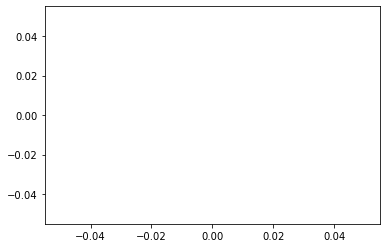

In [53]:
#flats_sample.set_index('ID', inplace=True)
flats_joined = flats_sample.join(onehot['sum'], how='left')
flats_joined['sum'].value_counts()

filter = flats_joined['RoomNr'] == 3.5
flats_filtered = flats_joined[filter]


plt.scatter(flats_filtered['sum'], flats_filtered['Price'])
flats_filtered.corr()